# Dependencies and Libraries

In [19]:
!pip install kaggle

In [20]:
!pip install tensorflow

In [21]:
from google.colab import files
import pandas as pd
import numpy as np
import re
import nltk
import json
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from sklearn.linear_model import LogisticRegression


In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gzip
import shutil
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Personal Kaggle API for importing dataset from Kaggle

In [24]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"cruzifire2001","key":"7165dec62de723c4f3b7fe7492fafeaf"}'}

In [25]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
!cp /content/kaggle.json ~/.kaggle/

In [27]:
!chmod 600 ~/.kaggle/kaggle.json

### Downloading Dataset

In [28]:
! kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 54% 14.0M/25.7M [00:00<00:00, 145MB/s]
100% 25.7M/25.7M [00:00<00:00, 179MB/s]


In [29]:
!unzip "/content/imdb-dataset-of-50k-movie-reviews.zip"

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: IMDB Dataset.csv        


In [30]:
!rm "/content/imdb-dataset-of-50k-movie-reviews.zip"

### DataFrame Name =movie_reviews

In [31]:
movie_reviews=pd.read_csv("/content/IMDB Dataset.csv")

In [32]:
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [33]:
movie_reviews.isnull().values.any()

False

### Visualizing Dataset

<ipython-input-34-27d17567fdb8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=movie_reviews, palette=colors)


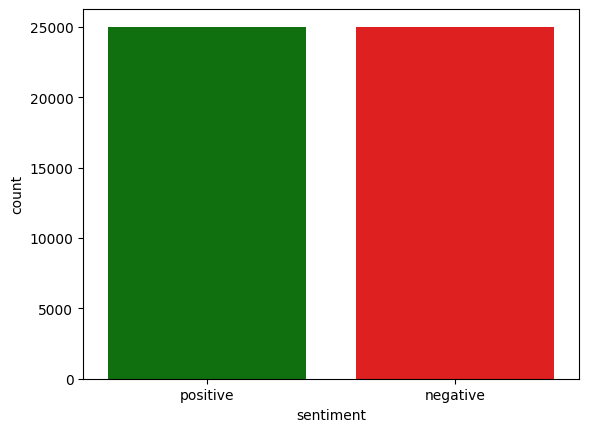

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors for each sentiment
colors = {"positive": "green", "negative": "red"}

# Create the countplot with custom colors
sns.countplot(x="sentiment", data=movie_reviews, palette=colors)

# Show the plot
plt.show()

In [35]:
movie_reviews["review"][2]


'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [36]:
sentiment_counts = movie_reviews['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Stopwords from NLTK to remove commonly used words like "the", "is", "and", etc

In [37]:
import nltk
from nltk.corpus import stopwords

In [38]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:

class TextPreprocessor:
    def __init__(self):
        # Use NLTK's predefined stopwords for English
        self.stopwords = set(stopwords.words('english'))

    def clean_html(self, text):
        html_pattern = re.compile('<.*?>')
        return html_pattern.sub('', text)

    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = self.clean_html(text)

        # Remove punctuations and numbers
        text = re.sub('[^a-zA-Z]', ' ', text)

        # Remove single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove stopwords
        words = text.split()
        filtered_words = [word for word in words if word not in self.stopwords]

        return ' '.join(filtered_words)

In [40]:
text_processor=TextPreprocessor()

In [41]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(text_processor.preprocess_text(sen))

In [42]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, movie_reviews['sentiment']))) # positive: 1, negative: 0

### Test Train Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [44]:
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 40000
Testing set size: 10000


### Tensorflow Tokenizer for maps words to numerical values, and now this numerical values represent the corresponding words.

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [46]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [47]:
len(X_train_seq[0])

202

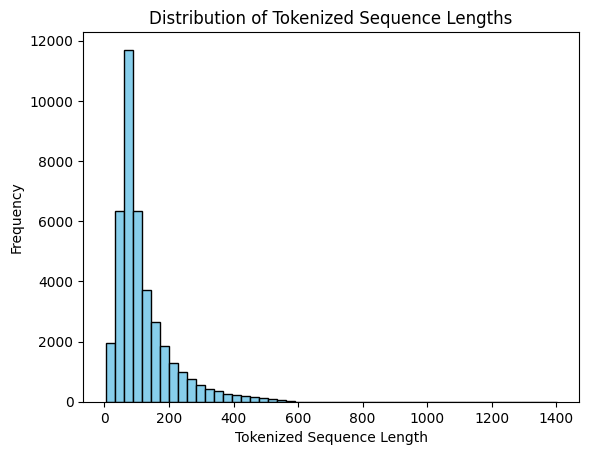

In [48]:
sequence_lengths = [len(seq) for seq in X_train_seq]

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Tokenized Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Sequence Lengths')
plt.show()

In [49]:
# Calculate some statistics for the tokenized sequence lengths
max_length = max(sequence_lengths)
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)

print(f"Max Length: {max_length}")
print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")



Max Length: 1401
Mean Length: 117.7861
Median Length: 88.0


In [50]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [51]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 92394


### Padding sequences to ensure that all input sequences have the same length(vector).

In [52]:
max_length = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [53]:
max_length

150

In [54]:
max_train_length_idx = max(range(len(X_train_seq)), key=lambda i: len(X_train_seq[i]))
max_train_length_sentence = sentences[max_train_length_idx]
print(f"Sentence with the maximum length in training data: \n{max_train_length_sentence}")

Sentence with the maximum length in training data: 
Dante would of been mortified, if he knew that his masterpiece was being ACTED OUT PUPPETS!!! Also the actors who played the puppets are sell outs. Due to the fact that playing a puppet is not acting it is just basically doing nothing. No one really will care who the puppet was. people only care who played a major role in like an actual movie. this is just annoying how you could mock such an amazing man and his belief, by this dumb little movie. This should be a crime and.... I cant believe you would ruin a book like that. I thought the movie was absolutely ridiculous and should be destroyed!!!! It totally ruins what your suppose to be getting from reading it. Your just making it a big joke.


In [55]:
X_train_padded.shape

(40000, 150)

### Downloading GloVe(Global Vectors for Word Representation)

In [56]:
github_url = "https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz"
gz_path = '/content/glove.6B.100d.txt.gz'
txt_path = '/content/glove.6B.100d.txt'


In [57]:
!wget -q {github_url} -O {gz_path}

In [58]:
with gzip.open(gz_path, 'rb') as f_in:
        with open(txt_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### GloVe for transforming the tokenized words (numbers) into dense word embeddings.
#### Word embeddings are pre-trained vectors that capture semantic relationships between words.

In [59]:
def load_glove_embeddings(file_path, word_index, embedding_dim=100):
    """Load GloVe embeddings and create an embedding matrix"""
    print("Loading GloVe embeddings...")
    embeddings_index = {}

    with open(file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors in GloVe file.")

    # Prepare embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [60]:
glove_path="/content/glove.6B.100d.txt"

In [61]:
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, embedding_dim)

Loading GloVe embeddings...
Found 400000 word vectors in GloVe file.


In [78]:

from tensorflow.keras.layers import Bidirectional

lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [79]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [80]:
lstm_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [81]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = lstm_model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
409/500 ━━━━━━━━━━━━━━━━━━━━ 1:13 810ms/step - accuracy: 0.6548 - loss: 0.6150

###Report

In [142]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.8847 - loss: 0.2777

LSTM Test Accuracy: 0.8867


In [143]:
y_pred_lstm = (lstm_model.predict(X_test_padded) > 0.5).astype("int32")


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step


In [144]:
print("\nLSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4961
           1       0.89      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



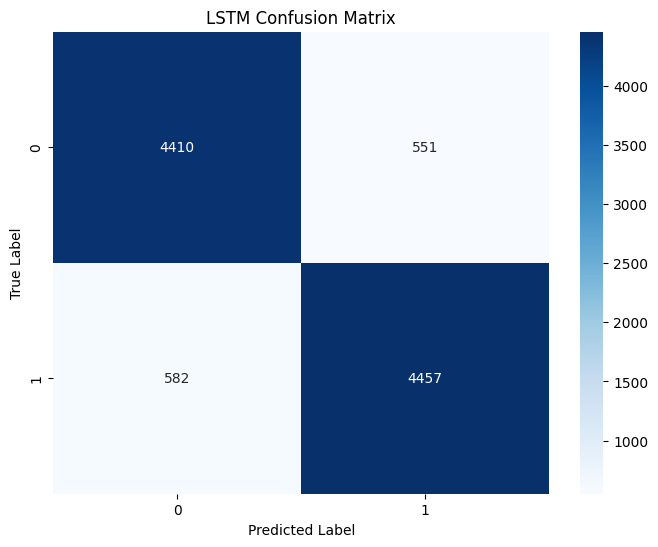

In [145]:
plt.figure(figsize=(8, 6))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

###Model Saving

In [146]:
lstm_model.save('movie_sentiment_lstm.h5')

###Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression


In [52]:
lr_tfidf = TfidfVectorizer(max_features=10000)
X_train_lr_tfidf = lr_tfidf.fit_transform(X_train)
X_test_lr_tfidf = lr_tfidf.transform(X_test)

In [53]:
print(f"\nTF-IDF feature shape for Logistic Regression: {X_train_lr_tfidf.shape}")



TF-IDF feature shape for Logistic Regression: (40000, 10000)


In [56]:
lr_model = LogisticRegression(C=1.0, solver='saga', max_iter=100, n_jobs=-1, random_state=42)
lr_model.fit(X_train_lr_tfidf, y_train)

LogisticRegression(n_jobs=-1, random_state=42, solver='saga')

In [57]:
y_pred_lr = lr_model.predict(X_test_lr_tfidf)


In [58]:
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.4f}")

Logistic Regression Test Accuracy: 0.8954


In [59]:
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



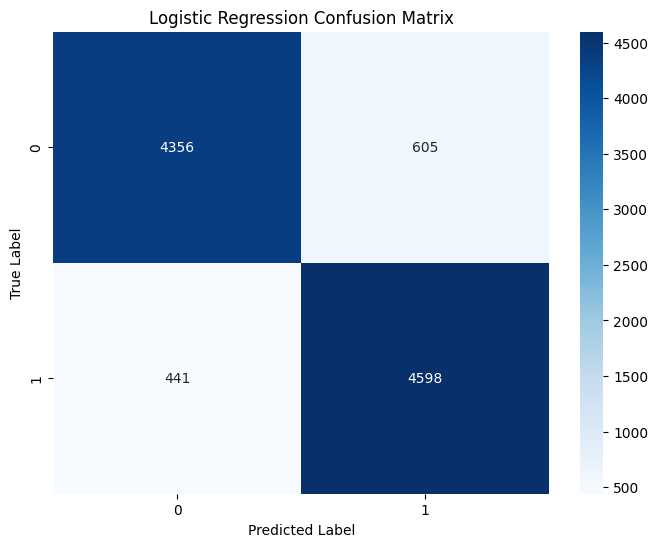

In [60]:
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Testing New Reviews from Users

In [83]:
#Data Accessing from Gform which is passed to spreadsheet
sheet_id = "17_VArxZnTaFg8uUAcoJ6PMjv0Gmq3YqOfxjfVCcowpQ"
sheet_name = "Form%20Responses%201"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
new_movie_reviews = pd.read_csv(csv_url)

In [84]:
new_movie_reviews["Review:"]

,Review:
0,"Its a good romantic movie, but the ending is r..."
1,"I didnot like this movie, because its complete..."
2,"The movie is not good, I felt the music and ba..."


In [87]:
random_review = new_movie_reviews["Review:"].sample(n=1).iloc[0]

In [88]:
print(random_review) # The movie is not good, I felt the music and background music were super good but Im not a fan of this type of movie personally

The movie is not good, I felt the music and background music were super good but Im not a fan of this type of movie personally 


###LSTM Prediction

In [147]:
cleaned_review = text_processor.preprocess_text(random_review)

In [148]:
new_sequence = tokenizer.texts_to_sequences([cleaned_review])

In [149]:
padded_sequence = pad_sequences(new_sequence, maxlen=max_length, padding='post')


In [150]:
prediction = lstm_model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [152]:
sentiment = "positive" if prediction >= 0.5 else "negative"
confidence = prediction if prediction >= 0.5 else 1 - prediction

print(f"Review: {random_review}")
print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.4f}")
print(f"Prediction score: {prediction:.4f}")

Review: The movie is not good, I felt the music and background music were super good but Im not a fan of this type of movie personally 
Sentiment: positive
Confidence: 0.8617
Prediction score: 0.8617


###Logistic Regression Prediction

In [89]:
processed_reviews = [text_processor.preprocess_text(random_review)]


In [90]:
vectorized_reviews_lr = lr_tfidf.transform(processed_reviews)
lr_predictions = lr_model.predict(vectorized_reviews_lr)

In [91]:
lr_sentiment = "Positive" if lr_predictions[0] == 1 else "Negative"

In [92]:
lr_sentiment

'Positive'